# Assignment 2
This assignment consists of 7 exercises (2 of which are optional) divided over two notebooks. Each exercise will come with some tests that are used to verify whether your code is correct. If you pass these tests then you are rewarded *full points*; if your code fails then you will get *no points*. Make sure to **read the rules** before you start the assignment.

## Rules
For this assignment the following rules apply:

**General**
 * The assignment should be completed with the same **groups of three** as the previous assignment
 * Any kind of intergroup discussion will be considered fraud and both the parties will be punished.
 * All code must be written intra group. All external help, with the exception of Python/library documentation and the lecture slides, will be considered fraud.
 * Do not use libraries that implement the assignment for you.

**Grading**
 * If a test cell runs without error (warnings are allowed) then you receive full points.
 * If a test cell throws an error for any reason then you receive 0 points.
  * If a cell takes more than five minutes to complete then this is considered an error.
 * If your code fails a test for *any reason* then you receive 0 points for that exercise.
 * Your grade is computed as $\frac{\text{points}}{\text{max_points}} * 9 + 1$ and will be rounded to the closest 0.5 point.
 * Submit your code to Brightspace as a zip file containing only the notebook (`*.ipynb`) files.
 * **Do not rename the notebook files**
 
**Late Submissions**
 * Late submissions must be submitted *as soon as possible* to the "Assignment 2 - Late Submissions" assignment on Brightspace.
 * The following penalty will be applied: $\text{adjusted grade} = \text{grade} - 1 - \lceil \frac{\text{minutes late}}{10} \rceil$

<br />
 
**Before you submit**, make sure that you are not accidentaly using any global variables. Restart the kernel (wiping all global variables) and run the code from top to bottom by clicking "Kernel" => "Restart & Run all" in the menu bar at the top.

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import scipy.sparse
import os
import sys
sys.path.append("../../")
import helpers

# Image Sharpening
In this set of exercises we will create an image sharpening filter. Image sharpening is the opposite of blurring (which we as last week): the filter takes a (slightly) blurry image and makes it sharper (less blurry). In these assignments we will implement a sharpening filter to sharpen a picture that is slightly out of focus. Another common use case for image sharpening is on televisions. By default most televisions are configured to apply a sharpening filter to make the image look crisper (sometimes to the decrement of image quality).

<!-- In the Poission image editing assignments we covered how image gradients characterize an image. By only changing the colors but not the gradients we were able to create a smooth transition without changing what was in the image. Gradients are thus play an important part in encoding image information.

In the first week you learned about blur filters such as the box and Gaussian blur. A blur operation smooths edges which results in lower magnitude gradients (spread out over a larger area). The goal of image sharpening is to perform the opposite operation: reducing the "blurryness" of an image. A common application of image sharpening is in TVs and video games. Where a lower resolution image is upscaled to match the output resolution, resulting in a blurry image. -->

## Images as vectors
Last week you learned to think of images as a 2D (grayscale) or 3D (color) array of values. This week we will use only vector (1D) representations for both types of images. The idea is to store all pixels  (and color channels) in an image as a vector for computation. After the computation we convert the vector back into a 2D/3D array representation.

There are many different possible ways to convert an image into a vector. None of them are necessarily incorrect as long as we write our filter correctly. But because of the way the grading/testing system works we will use one specific way of converting to/from a vector representation. Please use a vector representation which is the concatenation of the rows of an image:
<img src="pixel_numbering.png" alt="Pixel numbering" style="width: 25%;"/>


## Sharpening as a Linear System
*If you need a linear algebra refresher, then have a look at:*
https://www.tudelft.nl/en/eemcs/study/online-education/math-explained/linear-algebra/

As was discussed in the lectures, we can formulate a filter by defining a problem as a linear system that we need to solve. In the case of image sharpening we want to make edges more well defined. We can achieve this by amplifying the gradient vectors and from that computing a new image. We have to make sure however that we do not significantly change the colors by doing so.

Let's define $U$ as our new image vector, $\tilde{U}$ as our input image vector, $G$ as the gradient matrix and $c_s$ as the factor with which we want to scale the gradients. The gradient matrix computes a gradient vector from an image vector. A gradient vector defines the gradients between the pixels of the image represented by an image vector. We want to define our problem as an optimization problem where we want to find a new image whose colors match the original image but where the gradients are amplified. We can formulate this as follows (shortening the equations by replacing $\tilde{g}=G\tilde{U}$):

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = {\lvert GU - c_sG\tilde{U} \rvert}^2 = {\lvert GU - c_s\tilde{g} \rvert}^2 \\
& \text{subject to}
& & \lvert U - \tilde{U} \rvert = 0
\end{align}
$$

To formulate this optimization problem as a linear system we need to relax our constraints:

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = {\lvert GU - c_s\tilde{g} \rvert}^2 + \alpha {\lvert U - \tilde{U} \rvert}^2
\end{align}
$$

Here $\alpha$ is a constant used to scale the importance of the soft constraints ($\alpha=\infty$ would result in a hard constraint). We want to find the minimum of function $f(U)$. We know that at the minimum the derivative $f'(U) = 0$. Using this knowledge we can transform the problem into a linear system:

$$
\begin{align}
f(U) &= {\lvert GU - c_s\tilde{g} \rvert}^2 + \alpha {\lvert U - \tilde{U} \rvert}^2 \\
     &=  U^\intercal G^\intercal GU - 2c_sU^\intercal G^\intercal \tilde{g} + {c_s}^2 \tilde{g}^\intercal \tilde{g} + \alpha ({U^\intercal U + 2U^\intercal \tilde{U} + \tilde{U}^\intercal \tilde{U}}) \\
     &= U^\intercal (G^\intercal G + \alpha I)U - 2U^\intercal (c_s G^\intercal \tilde{g} + \alpha \tilde{U}) + {c_s}^2 \tilde{g}^\intercal \tilde{g} + \alpha \tilde{U}^\intercal \tilde{U} \\
\\
f'(U) &= 2(G^\intercal G + \alpha I)U - 2(c_s G^\intercal \tilde{g} + \alpha \tilde{U}) \\
\end{align}
$$

$$
\begin{align}
2(G^\intercal G + \alpha I)U - 2(c_s G^\intercal \tilde{g} + \alpha \tilde{U}) &= 0 \\
(G^\intercal G + \alpha I)U &= c_s G^\intercal \tilde{g} + \alpha \tilde{U} \\
\end{align}
$$

In this formula $I$ is an identity matrix (`1` on the diagonal, `0` everywhere else) with as many rows and columns as there are pixels.


### Image Gradients
There are many different ways in which order the gradients may appear in the gradient vector. Again we ask you to strictly adhere to the following definition so we don't have to manually test your solution.

Without the restrictions of convolutions we can now define gradients *between* pixels instead of at pixels. We compute the gradient as follows: $g_x(x+0.5, y) = \frac{1}{2}(I(x+1, y) - I(x,y)$ and $g_y(x, y+0.5) = \frac{1}{2}(I(x, y+1) - I(x, y) )$. Because we define gradients between neighbouring pixel pairs we will have $\#g_x + \#g_y = (\text{width}-1) \cdot \text{height} + \text{width} \cdot (\text{height}-1)$ gradient values in total.

<!-- https://stackoverflow.com/questions/24319505/how-can-one-display-images-side-by-side-in-a-github-readme-md -->
Gradient X           |  Gradient Y
:-------------------------:|:-------------------------:
![](gradient_x.png)  |  ![](gradient_y.png)

## Exercise 1 (2 points)
Implement a function which construct the gradient matrix for images of a given shape. Make sure that you adhere to the format specified above. Use `scipy.sparse.lil_matrix((num_rows, num_columns))` to construct a sparse matrix and convert it to a `scipy.sparse.csr_matrix` before returning it. A `lil_matrix` can be accessed just like a regular numpy array.

**WARNING**: the grading script requires the entries in the gradient *vector* to be ordered in one specific way. The gradient *vector* should contain all $g_x^i$ followed by all $g_y^i$ (so $g=(g_x^0, ..., g_x^n, g_y^0, ..., g_y^n)^T$). The $g_x$ and $g_y$ values should be ordered from left to right and from top to bottom. Make sure to use this notation in both notebooks.

In [13]:
def construct_G(width, height):
    num_gradients = (width-1)*height + (height-1)*width
    num_pixels = width*height
    G = scipy.sparse.lil_matrix((num_gradients, num_pixels))
    next_empty = 0
    for i in range(height):
        for j in range(width-1):
            index = i * width + j
            G[next_empty, index] = -0.5
            G[next_empty, index+1] = 0.5
            next_empty += 1
    
    for i in range(height-1):
        for j in range(width):
            index = i * width + j
            G[next_empty, index] = -0.5
            G[next_empty, index+width] = 0.5
            next_empty += 1

    # Convert scipy.sparse.lil_matrix to scipy.sparse.csr_matrix for efficient processing
    return scipy.sparse.csr_matrix(G)

print(construct_G(2, 2).toarray())

[[-0.5  0.5  0.   0. ]
 [ 0.   0.  -0.5  0.5]
 [-0.5  0.   0.5  0. ]
 [ 0.  -0.5  0.   0.5]]


### Testing your solution of exercise 1
The following visualization helps you to validate whether the gradients that you have computed are correct. The $G_x$ and $G_y$ images show the horizontal and vertical derivatives (scaled by a factor of 5 for improved visibility) as computed by your gradient matrix.

Below there are a couple simple tests to verify some basic requirements.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
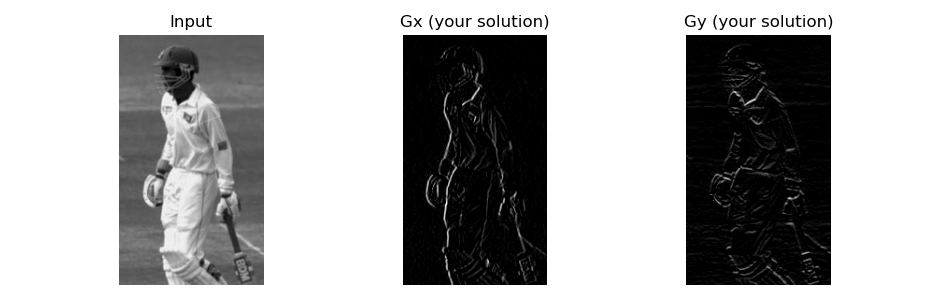

In [14]:
def construct_U(color_channel):
    # Creates image vector
    return color_channel.flatten()

def gradient_vector_to_image_gx(g, width ,height):
    out = np.zeros((height, width-1))
    
    for y in range (height):
        for x in range(width-1):
            index = y * (width - 1) + x
            out[y, x] = g[index]
            
    return out

def gradient_vector_to_image_gy(g, width ,height):
    out = np.zeros((height-1, width))
    
    num_gx = (width-1) * height
    for y in range (height-1):
        for x in range(width):
            index = num_gx + y * width + x
            out[y, x] = g[index]
            
    return out

blurry_grayscale = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "blurry.png"), 0.25)
height, width = blurry_grayscale.shape

image_vector = construct_U(blurry_grayscale)
gradient_vector = construct_G(width, height) @ image_vector

gx_image = gradient_vector_to_image_gx(gradient_vector, width, height)
gy_image = gradient_vector_to_image_gy(gradient_vector, width, height)

# Increase contrast
gx_image = np.clip(5 * gx_image, 0, 1)
gy_image = np.clip(5 * gy_image, 0, 1)

helpers.show_images({ "Input": blurry_grayscale, "Gx (your solution)": gx_image, "Gy (your solution)": gy_image }, nrows=1, ncols=3)

In [16]:
# Simple tests (constructing G for a 4x4 image)
w = h = 4
G = construct_G(w, h)

num_pixels = w * h
num_gradient_components = (w-1)*h + w*(h-1)
assert(G.shape == (num_gradient_components, num_pixels))
# The first horizontal gradient (between pixels 0 and 1)
assert(G[0,0] == -0.5)
assert(G[0,1] == 0.5)


## Exercise 2 (2 points)
Implement the sharpening filter as was described earlier. The function should take a (2D) image of a single color channel and should output a sharpened (2D) image for that color channel. The function that applies this operation to each of the color channels is provided for you.

Make use of `construct_U` to convert an image to a vector and `construct_I` to create an identity matrix. The gradient matrix $G$ is provided so that this exercise does not become impossible if you failed the first assignment. Use `scipy.sparse.linalg.spsolve` ([documentation](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html)) to solve the linear system (which solves $A\vec{x}=\vec{b}$ where $\vec{x}$ is the unknown).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
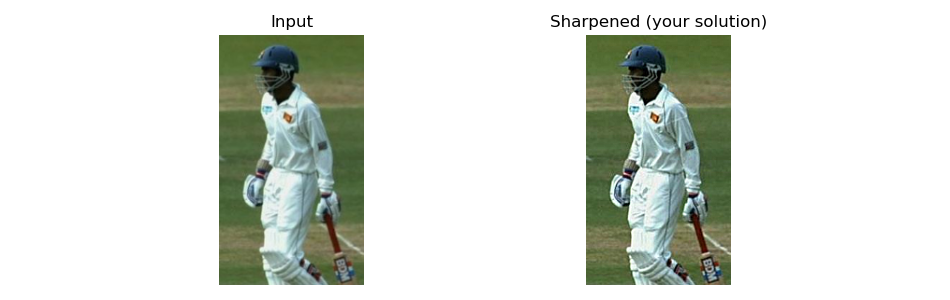

In [19]:
# Constructs a (n x n) identity matrix
def construct_I(n):
    I = scipy.sparse.lil_matrix((n, n))
    I.setdiag(1)
    return scipy.sparse.csr_matrix(I)

def sharpen_color_channel(color_channel, G, cs, alpha):
    U = construct_U(color_channel)
    g = G @ U
    I = construct_I(G.shape[1])
    
    b = cs * G.T @ g + alpha * U
    A = G.T @ G + alpha * I
    sharpened_image = scipy.sparse.linalg.spsolve(A, b)
    return np.reshape(sharpened_image, color_channel.shape)


def sharpen_image(image, G, cs, alpha):
    red_channel = sharpen_color_channel(image[:,:,0], G, cs, alpha)
    green_channel = sharpen_color_channel(image[:,:,1], G, cs, alpha)
    blue_channel = sharpen_color_channel(image[:,:,2], G, cs, alpha)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)


blurry_rgb = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "blurry.png"), 0.25)
reference_G = scipy.sparse.load_npz(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "reference_G.npz"))
sharpened_rgb = np.clip(sharpen_image(blurry_rgb, reference_G, 3, 0.5), 0, 1)
helpers.show_images({ "Input": blurry_rgb, "Sharpened (your solution)": sharpened_rgb }, nrows=1, ncols=2)

### Testing your solution of exercise 2
The sharpening filter should make the image have sharper edges and thus appear less blurry. The following visualization shows the gradient magnitudes of the two images. The sharpened image should have higher gradient magnitudes.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
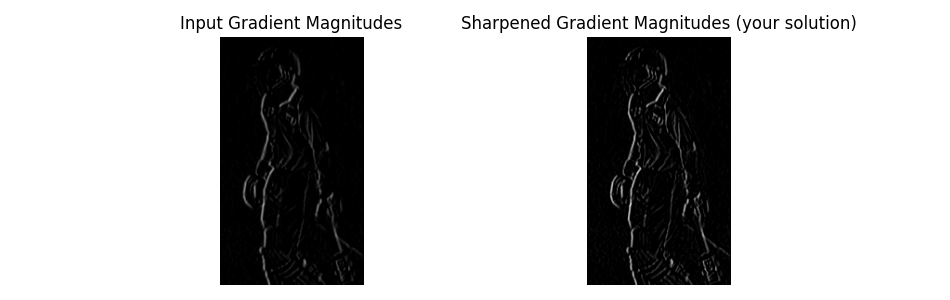

In [6]:
blurry_rgb = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "blurry.png"), 0.25)
reference_G = scipy.sparse.load_npz(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "reference_G.npz"))
sharpened_rgb = np.clip(sharpen_image(blurry_rgb, reference_G, 3, 0.5), 0, 1)

input_gradient_magnitudes = scipy.ndimage.sobel(helpers.rgb2gray(blurry_rgb)) / 4
sharpened_gradient_magnitudes = scipy.ndimage.sobel(helpers.rgb2gray(sharpened_rgb)) / 4

helpers.show_images({
    "Input Gradient Magnitudes": input_gradient_magnitudes,
    "Sharpened Gradient Magnitudes (your solution)": sharpened_gradient_magnitudes
}, nrows=1, ncols=2)